# Causal Inference Analysis on "Pakistan Largest Ecommerce Dataset"

This notebook explores this dataset to answer the following questions:

1. **Customer Segmentation and Causal Relationships**  
   - How can customers be segmented into distinct categories based on their buying behavior?
   - What are the causal relationships between these categories and factors such as product choices, order frequency, and marketing strategies?

2. **Temporal Patterns, Discounts, and Sales Commissions**  
   - How do temporal patterns, discount strategies, and sales commissions influence ordering behavior, revenue generation, and order quantity across product categories?
   - What causal relationships can be identified to forecast future order trends?

---

### Steps Involved
1. Load and explore the dataset.
2. Clean the dataset to handle missing values
3. Preprocess the data to format dates, and create necessary features.
4. Analyze causal relationships using causal inference methods.
5. Forecast future trends using temporal models.
6. Categorise consumers according to thier ordering frequency
7. Calculate conditional Average treatment affect on different product and customer categories for different strategies


---

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary libraries
#!pip install dowhy # To install dowhy
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

# Causal inference and time-series modeling libraries
from dowhy import CausalModel

In [ ]:
# Load the dataset
path = "drive/MyDrive/Pakistan Largest Ecommerce Dataset.csv"
data = pd.read_csv(path)

# Overview of dataset structure and columns
print("Dataset Info:")
print(data.info())
print("\nColumn Names:", data.columns.tolist())

# Check for missing values
print("\nMissing Values per Column:")
print(data.isnull().sum())

# Basic descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(data.describe(include='all'))

<ipython-input-4-679e6e811724>:4: DtypeWarning: Columns (1,2,3,7,8,9,11,12,13,14,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                584524 non-null  float64
 1   status                 584509 non-null  object 
 2   created_at             584524 non-null  object 
 3   sku                    584504 non-null  object 
 4   price                  584524 non-null  float64
 5   qty_ordered            584524 non-null  float64
 6   grand_total            584524 non-null  float64
 7   increment_id           584524 non-null  object 
 8   category_name_1        584360 non-null  object 
 9   sales_commission_code  447346 non-null  object 
 10  discount_amount        584524 non-null  float64
 11  payment_method         584524 non-null  object 
 12  Working Date           584524 non-null  object 
 13  BI Status              584524 non-null  object 
 14   MV                 

In [ ]:
# Data Cleaning
# Convert columns with possible mixed types (e.g., 'price' and 'grand_total') to numeric, handling errors
for col in ['price', 'qty_ordered', 'grand_total']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Handling missing values
data = data.dropna(subset=['price', 'qty_ordered', 'grand_total'])  # Drop rows with NaNs in key columns
data.loc[:,"sales_commission_code"] = data["sales_commission_code"].fillna("\\N")
data = data.drop(["Unnamed: 21","Unnamed: 22","Unnamed: 23","Unnamed: 24","Unnamed: 25"], axis = 1)
data = data.dropna()
data = data.loc[data["category_name_1"] != '\\N']
# Removing duplicates
data = data.drop_duplicates()
print("Duplicates removed:", data.duplicated().sum())

print("\nCleaned Data Info:")
print(data.info())

Duplicates removed: 0

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 576481 entries, 0 to 584523
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_id                576481 non-null  float64
 1   status                 576481 non-null  object 
 2   created_at             576481 non-null  object 
 3   sku                    576481 non-null  object 
 4   price                  576481 non-null  float64
 5   qty_ordered            576481 non-null  float64
 6   grand_total            576481 non-null  float64
 7   increment_id           576481 non-null  object 
 8   category_name_1        576481 non-null  object 
 9   sales_commission_code  576481 non-null  object 
 10  discount_amount        576481 non-null  float64
 11  payment_method         576481 non-null  object 
 12  Working Date           576481 non-null  object 
 13  BI Status              576481 non-null  object 
 14 

In [ ]:
# Data Preprocessing

# Convert 'Working Date' to datetime format
data['Working Date'] = pd.to_datetime(data['Working Date'], errors='coerce')

# Add necessary features like year, month, and total spend per customer
data['Year'] = data['Working Date'].dt.year
data['Month'] = data['Working Date'].dt.month

# Display basic statistics
data.describe()


,item_id,price,qty_ordered,grand_total,discount_amount,Working Date,Year,Month,Customer ID
count,576481.000000,5.764810e+05,576481.000000,5.764810e+05,576481.000000,576481,576481.000000,576481.000000,576481.000000
mean,568856.240589,6.380576e+03,1.295198,8.586697e+03,503.305058,2017-08-11 17:20:58.692654080,2017.054510,7.149214,46223.962686
min,211131.000000,0.000000e+00,1.000000,-1.594000e+03,-599.500000,2016-07-01 00:00:00,2016.000000,1.000000,1.000000
25%,400805.000000,3.600000e+02,1.000000,9.520000e+02,0.000000,2017-02-09 00:00:00,2017.000000,4.000000,13922.000000
50%,572624.000000,9.000000e+02,1.000000,1.986500e+03,0.000000,2017-08-24 00:00:00,2017.000000,7.000000,43575.000000
75%,741159.000000,4.053000e+03,1.000000,6.998000e+03,164.978200,2018-02-09 00:00:00,2018.000000,11.000000,74002.000000
max,905208.000000,1.012626e+06,1000.000000,1.788800e+07,90300.000000,2018-08-28 00:00:00,2018.000000,12.000000,115326.000000
std,199132.748914,1.500691e+04,3.997739,6.173179e+04,1510.672047,NaN,0.704198,3.488543,34392.991598


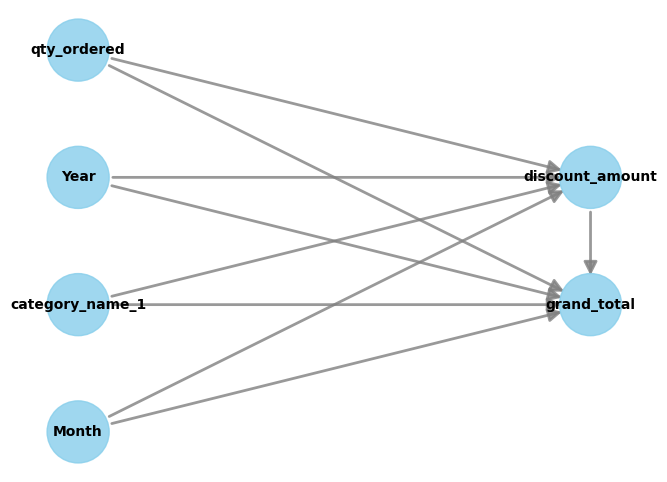

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                               
─────────────────(E[grand_total|Month,category_name_1,Year,qty_ordered])
d[discountₐₘₒᵤₙₜ]                                                       
Estimand assumption 1, Unconfoundedness: If U→{discount_amount} and U→grand_total then P(grand_total|discount_amount,Month,category_name_1,Year,qty_ordered,U) = P(grand_total|discount_amount,Month,category_name_1,Year,qty_ordered)

## Realized estimand
b: grand_total~discount_amount+Month+category_name_1+Year+qty_ordered
Target units: ate

## Estimate
Mean value: 2.853324612601682



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [ ]:
# Causal Inference Analysis

# Define a causal model
model = CausalModel(
    data=data,
    treatment="discount_amount",
    outcome="grand_total",
    common_causes=["qty_ordered", "Year", "Month", "category_name_1"]
)

# Display causal graph
model.view_model()
from IPython.display import Image
Image(filename="causal_model.png")

# Estimate causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate)

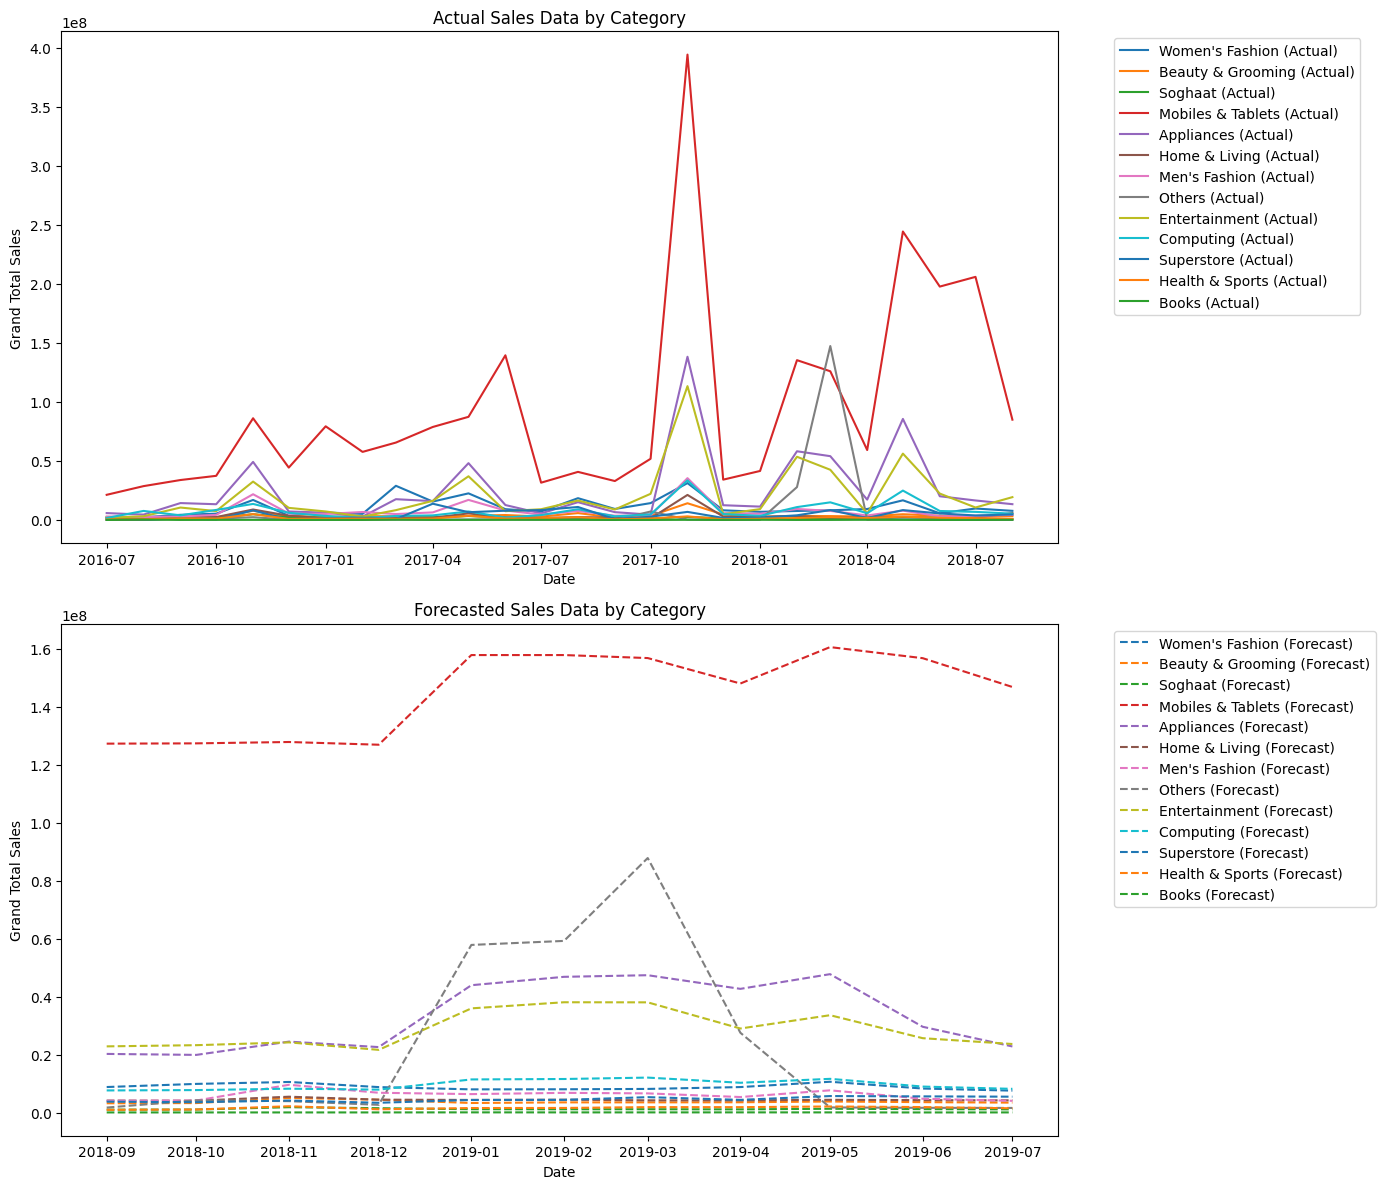

In [ ]:
# Aggregate data by month and category
monthly_data = data.groupby(['Year', 'Month', 'category_name_1'])[['grand_total', 'qty_ordered']].sum().reset_index()

# Ensure Year and Month are integers
monthly_data['Year'] = monthly_data['Year'].astype(int)
monthly_data['Month'] = monthly_data['Month'].astype(int)

# Add a datetime column
monthly_data['Date'] = pd.to_datetime(monthly_data[['Year', 'Month']].assign(Day=1))

# Unique categories
categories = [
    "Women's Fashion", "Beauty & Grooming", "Soghaat", "Mobiles & Tablets", "Appliances",
    "Home & Living", "Men's Fashion", "Others", "Entertainment", "Computing",
    "Superstore", "Health & Sports", "Books",
] # Not including columns with insufficient data

# Dictionary to store forecasts
forecast_dict = {}

# Plot setup
fig, axes = plt.subplots(2, 1, figsize=(14, 12))  # Two subplots: one for actual and one for forecasted

for category in categories:
    # Filter data for the category
    category_data = monthly_data[monthly_data['category_name_1'] == category]
    category_data = category_data.sort_values('Date')

    # Ensure there is enough data for Random Forest
    if len(category_data) < 12:  # Require at least 12 months of data
        print(f"Skipping category {category} due to insufficient data")
        continue

    # Create features and target
    category_data['time_index'] = np.arange(len(category_data))  # Create time index
    category_data['month'] = category_data['Date'].dt.month  # Extract month as a feature

    X = category_data[['time_index', 'month']]  # Features
    y = category_data['grand_total']            # Target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit Random Forest model with increased depth
    try:
        rf_model = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=42)  # Increased max_depth
        rf_model.fit(X_train, y_train)

        # Forecast future values
        future_time_indices = np.arange(len(category_data), len(category_data) + 11)  # Next 11 time indices
        future_months = [(category_data['Date'].max().month + i - 1) % 12 + 1 for i in range(1, 12)]
        future_features = pd.DataFrame({
            'time_index': future_time_indices,
            'month': future_months
        })

        forecast = rf_model.predict(future_features)
        forecast_dict[category] = forecast

        # Plot historical data on the first subplot
        axes[0].plot(category_data['Date'], category_data['grand_total'], label=f'{category} (Actual)')

        # Plot forecasted values on the second subplot
        future_dates = pd.date_range(start=category_data['Date'].max(), periods=12, freq='MS')[1:]
        axes[1].plot(future_dates, forecast, linestyle='--', label=f'{category} (Forecast)')
    except Exception as e:
        print(f"Skipping category {category} due to error: {e}")

# Customize actual data subplot
axes[0].set_title("Actual Sales Data by Category")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Grand Total Sales")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize forecasted data subplot
axes[1].set_title("Forecasted Sales Data by Category")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Grand Total Sales")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**The fucntion below calculates ATE on function provided for the treatment column while conditioning on the columns specified in codition variable**

In [ ]:
def ate_cal(df, treatment, condition,func):
  possible_treatments = df[treatment].unique()
  # to get x axis in order
  try:
    possible_treatments = np.array(sorted(possible_treatments,key=lambda x: pd.to_numeric(x.split()[0])))
  except:
    pass
  if possible_treatments.size == 2:
    possible_treatments = [1]
  sl_ATE_f = 0
  lis_ate = []
  lis_cat = []
  # apply each type as a treatment
  for i in possible_treatments:
    # ATE without conditioning
    ATE = df.loc[df[treatment] == i, "grand_total"].agg(func) -  df.loc[df[treatment] != i, "grand_total"].agg(func)
    p1 = df.loc[df[treatment] == i].groupby(condition)["grand_total"].agg(func)
    ind1 = set(p1.index)
    p2 = df.loc[df[treatment] != i].groupby(condition)["grand_total"].agg(func)
    ind2 = set(p2.index)
    # take intersection to not include invalid indices
    ind = list(ind1 & ind2)
    sl_ATE = p1[ind] - p2[ind]
    ATE = df.loc[df[treatment] == i, "grand_total"].agg(func)  -  df.loc[df[treatment] != i, "grand_total"].agg(func)
    sl_ATE = df.loc[df[treatment] == i].groupby(condition)["grand_total"].agg(func)[ind] -  df.loc[df[treatment] != i].groupby(condition)["grand_total"].agg(func) [ind]
    lis_cat.append(i)
    print(f"ATE of {treatment} ({i}) for people devided into subgroups on the basis of {condition}:")
    sl_ATE_f = sl_ATE * (df.groupby(condition)["grand_total"].count()/df.shape[0])[sl_ATE.index]
    sl_ATE_f = sl_ATE_f.sum()
    lis_ate.append(sl_ATE_f)
    print(f"overall ATE calculated for impact of being in customer class: {i}: ",ATE)
    print(f"overall ATE calculated for impact of being in customer class: {i} (conditioned on {condition}):" , sl_ATE_f)

    # get and report pre-conditioning statistical significance
    t_group = df.loc[(df[treatment] == i)]
    c_group = df.loc[(df[treatment] != i)]
    t_group = t_group["grand_total"]
    c_group = c_group["grand_total"]
    ans = scipy.stats.ttest_ind(t_group, c_group,equal_var=True)
    p_value = ans[1]
    print("p_value (statistical significance) without conditioning: ",p_value)
    print()
  return lis_ate, lis_cat

**We calculate ATE on the average cart_size due to discount and sales comission. We observe that for some categories sales comission does increase the average cart size while for most of the categories it has little to no impact. discount on the other hand reduces the average cart size. This could be due to the fact that discount might be more apealing to price sensitive users that tend to buy cheaper goods. So discount might primarily effect order count**

Women's Fashion
ATE of sales commision (1) for people devided into subgroups on the basis of ['Month', 'discount', 'payment_method', 'Year']:
overall ATE calculated for impact of being in customer class: 1:  -775.900398533206
overall ATE calculated for impact of being in customer class: 1 (conditioned on ['Month', 'discount', 'payment_method', 'Year']): -228.64992804591367
p_value (statistical significance) without conditioning:  1.222203751175579e-11

ATE of discount (1) for people devided into subgroups on the basis of ['Month', 'payment_method', 'Year', 'sales commision']:
overall ATE calculated for impact of being in customer class: 1:  -694.5724017559178
overall ATE calculated for impact of being in customer class: 1 (conditioned on ['Month', 'payment_method', 'Year', 'sales commision']): -1823.9837203993266
p_value (statistical significance) without conditioning:  1.8175196947938282e-17

ATE of discount and sales commision (1) for people devided into subgroups on the basis of ['M

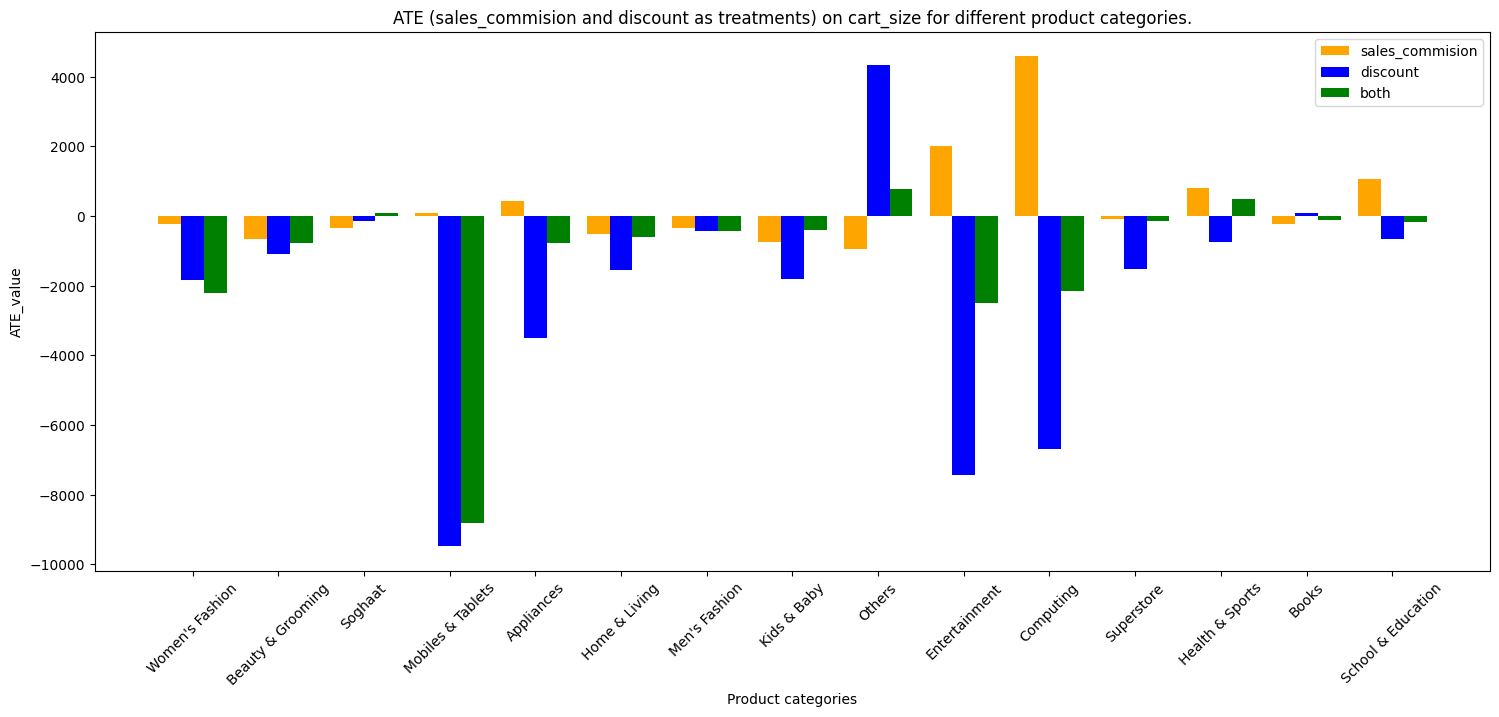

In [ ]:
lis_ate = []
lis_cat = []
lis_ate2 = []
lis_ate3 = []
options = data["category_name_1"].unique()
# make new columns to hold information about discount and sales commision, assuming that these treatments do not have varying doses
data["discount and sales commision"] = (data["discount_amount"] > 0) & (data["sales_commission_code"] != "\\N").astype(int)
data["discount"] = (data["discount_amount"] > 0).astype(int)
data["sales commision"] = (data["sales_commission_code"] != "\\N").astype(int)
# how does certain features effect each product category
for i in options:
    print(i)
    import scipy
    lis_cat.append(i)
    ans,_ = ate_cal(data.loc[data["category_name_1"] == i], "sales commision", ["Month","discount","payment_method","Year"], 'mean')
    an2,_ = ate_cal(data.loc[data["category_name_1"] == i], "discount", ["Month","payment_method","Year","sales commision"], 'mean')
    ans3,_ = ate_cal(data.loc[data["category_name_1"] == i], "discount and sales commision", ["Month","payment_method","Year"], 'mean')
    lis_ate.append(ans[0])
    lis_ate2.append(an2[0])
    lis_ate3.append(ans3[0])

#plot as bar graphs on the same plot
width = 0.8
bar1 = [3*i for i in range(len(lis_cat))]
bar2 = [i + width for i in bar1]
bar3 = [i + width for i in bar2]
plt.figure(figsize=(18,7))
plt.bar(bar1, lis_ate,width, label = "sales_commision", color="orange")
plt.bar(bar2, lis_ate2,width, label = "discount" , color="blue")
plt.bar(bar3, lis_ate3,width, label = "both", color="green")
plt.xticks(bar2, lis_cat)
plt.xticks(rotation = 45)
plt.title("ATE (sales_commision and discount as treatments) on cart_size for different product categories.")
plt.xlabel("Product categories")
plt.ylabel("ATE_value")
plt.legend()
plt.show()

**due to the limitation of data accross years, to get the impact of discount and sales comission we use another strategy. We observe the effect of changing the fiscal on the order count. We do this first by conditioning on "dicounts", then conditioning on "sales comission" and then not conditioning on any of these variables. we obsereve that without conditioning on discount the positive effect on order count increase. suggesting that discount has positive impact on the number of orders placed**

Women's Fashion
ATE of year_2018 (1) for people devided into subgroups on the basis of ['discount', 'payment_method']:
overall ATE calculated for impact of being in customer class: 1:  4819
overall ATE calculated for impact of being in customer class: 1 (conditioned on ['discount', 'payment_method']): 498.0189775584319
p_value (statistical significance) without conditioning:  0.33297975528684887

ATE of year_2018 (1) for people devided into subgroups on the basis of ['payment_method', 'sales commision']:
overall ATE calculated for impact of being in customer class: 1:  4819
overall ATE calculated for impact of being in customer class: 1 (conditioned on ['payment_method', 'sales commision']): 1959.0241549492503
p_value (statistical significance) without conditioning:  0.33297975528684887

ATE of year_2018 (1) for people devided into subgroups on the basis of ['payment_method']:
overall ATE calculated for impact of being in customer class: 1:  4819
overall ATE calculated for impact of be

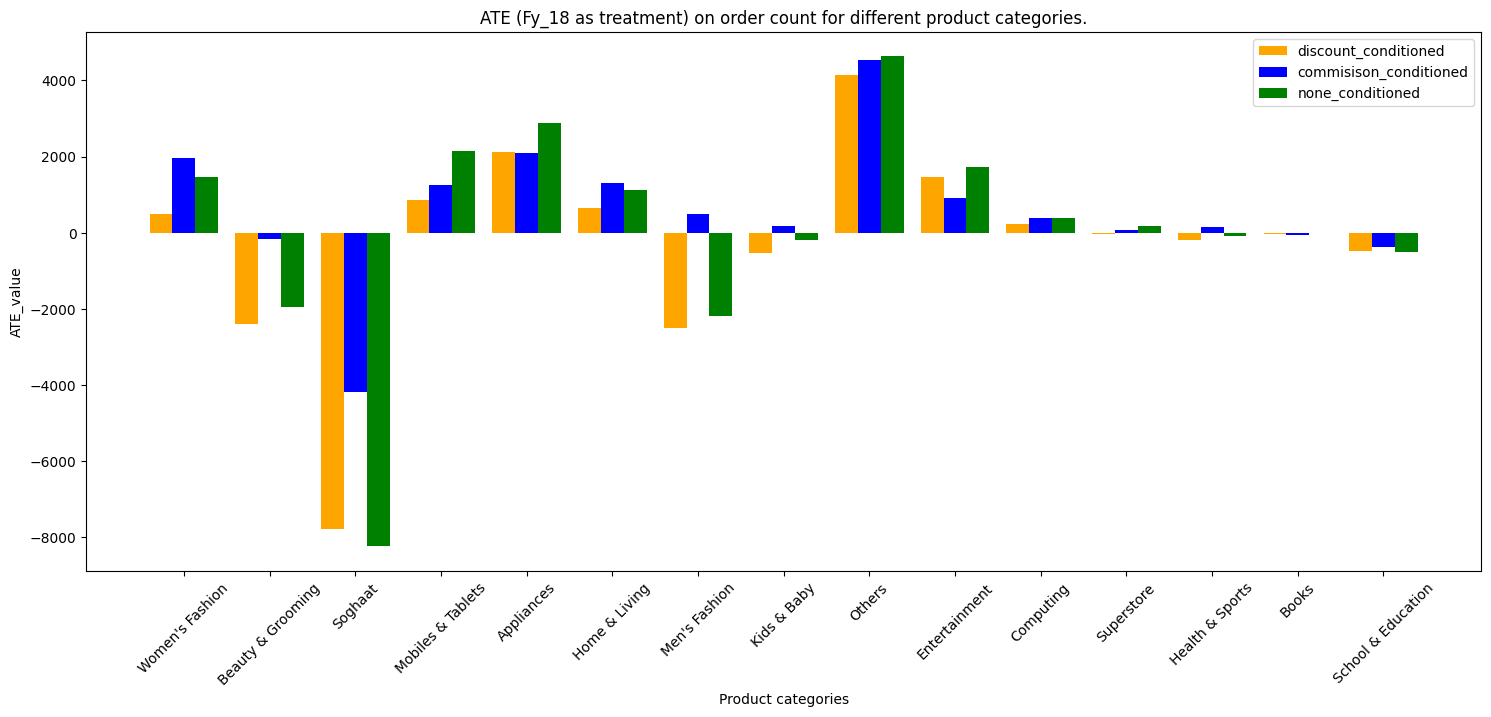

In [ ]:
lis_ate = []
lis_cat = []
lis_ate2 = []
lis_ate3 = []
options = data["category_name_1"].unique()
data["year_2018"] = (data["FY"] == "FY18").astype(int)
for i in options:
    print(i)
    lis_cat.append(i)
    ans,_ = ate_cal(data.loc[(data["category_name_1"] == i) & ((data["FY"] == "FY17") | (data["FY"] == "FY18")) & (data["Month"] != 6)], "year_2018", ["discount","payment_method"], 'count')
    an2,_ = ate_cal(data.loc[(data["category_name_1"] == i) & ((data["FY"] == "FY17") | (data["FY"] == "FY18"))& (data["Month"] != 6)], "year_2018", ["payment_method","sales commision"], 'count')
    ans3,_ = ate_cal(data.loc[(data["category_name_1"] == i) & ((data["FY"] == "FY17") | (data["FY"] == "FY18")) & (data["Month"] != 6)], "year_2018", ["payment_method"], 'count')
    lis_ate.append(ans[0])
    lis_ate2.append(an2[0])
    lis_ate3.append(ans3[0])

width = 0.8
bar1 = [3*i for i in range(len(lis_cat))]
bar2 = [i + width for i in bar1]
bar3 = [i + width for i in bar2]
plt.figure(figsize=(18,7))
plt.bar(bar1, lis_ate,width, label = "discount_conditioned", color="orange")
plt.bar(bar2, lis_ate2,width, label = "commisison_conditioned" , color="blue")
plt.bar(bar3, lis_ate3,width, label = "none_conditioned", color="green")
plt.xticks(bar2, lis_cat)
plt.xticks(rotation = 45)
plt.title("ATE (Fy_18 as treatment) on order count for different product categories.")
plt.xlabel("Product categories")
plt.ylabel("ATE_value")
plt.legend()
plt.show()

**We categorise customers according to thier order frequency**



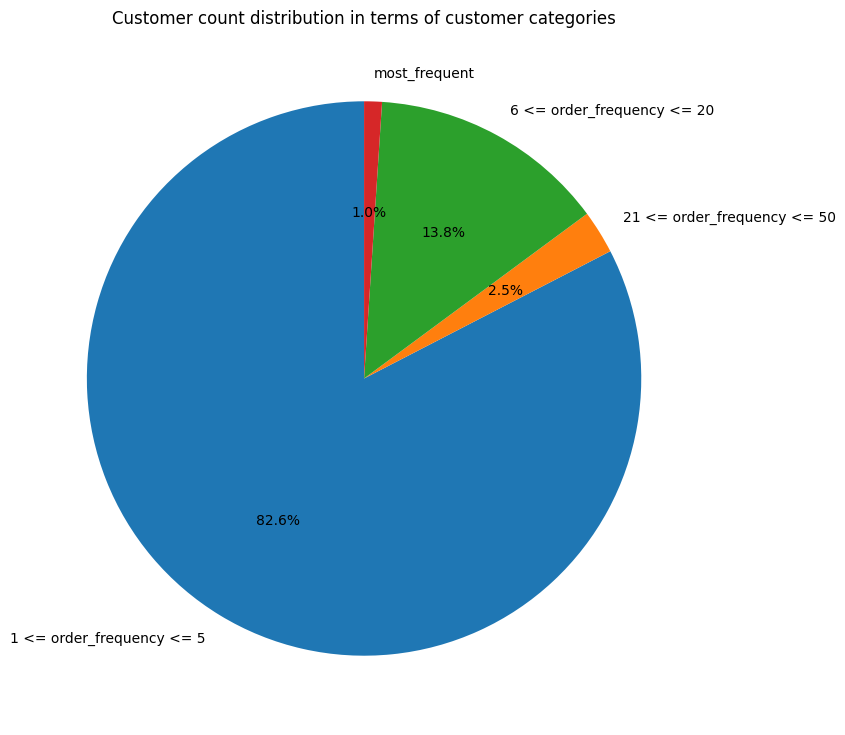

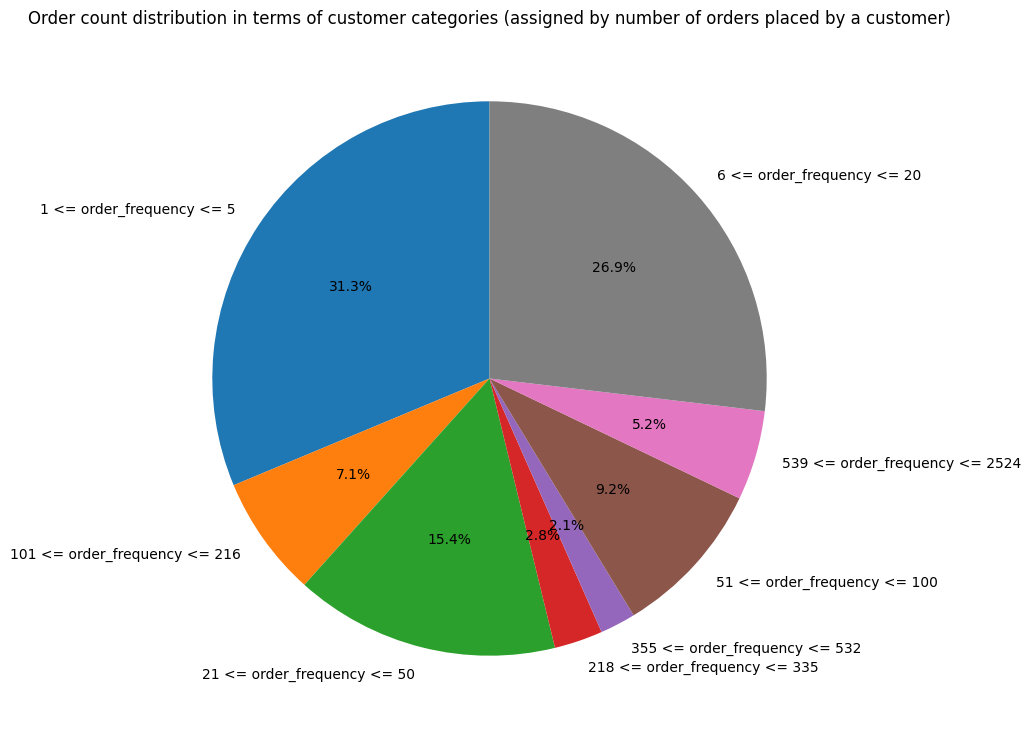

In [ ]:
# want to find percentage of complete orders and total orders for each customer, use groupby and a custom function to do it
grp_df = data.groupby("Customer ID")[["item_id","status"]].agg(
    {
    "status": lambda x: (x == "complete").sum()/x.shape[0],
    "item_id": "count",
}
)
#new series that hold order count for each customer, convert it to df so could just merge on one coulmn
new_s = grp_df["item_id"]
new_s = new_s.reset_index()
new_s.columns = ["Customer ID","order_count"]
#add order count correctky alligned to each customer
new_data = pd.merge(data,new_s, on='Customer ID')
#adding an new empty column to my df
new_data["customer_category"] = pd.Series([None]*new_data.shape[0])
# status in grp_df has percentage of complete order, want to categorise by order count that is why group on it. using median because mean gave a little skewed result for catgeories with less cutomers
grp_df2 = grp_df.groupby("item_id")["status"].agg('median')
#sort because in for loop, use sorted property to assign values to bin
ind = grp_df2.index.sort_values().to_list()
final_y = (grp_df2[ind]).to_list()
new_y = []
new_x = []
#arbitrary bin size
bins = [5,15,30 ,50,100,50, 25,30]
count = 0
for i in bins:
    sum = 0
    # find average completion status for each category
    for j in range(i):
        sum = sum + final_y[count+j]
    index = (new_data["order_count"] <= ind[count+i-1]) & (new_data["order_count"] >= ind[count])
    new_data.loc[index,"customer_category"] = f'{ind[count]} <= order_frequency <= {ind[count + i-1]}'
    new_y.append(sum/i)
    new_x.append(f'{ind[count]} <= order_frequency <= {ind[count + i-1]}')
    count = count + i
##############################################################################################
#finding number of cutomers in each category
df_group = new_data.groupby("customer_category")["Customer ID"].agg(lambda x: x.unique().shape[0])
# put all categories contributing less than 1.5 percent in the other category
ind = df_group/df_group.sum() < 0.015
dumy = df_group[ind].sum()
#new series to account for categories accounting for less than 1.5 percent
new_s = pd.Series([dumy], index = ["most_frequent"])
df_group = pd.concat([df_group, new_s])
#making index series to include the newly created category
ind = pd.concat([ind, pd.Series([False], index = ["most_frequent"])])
plt.figure(figsize=(9,9))
plt.pie(df_group.values[~ind], labels=df_group.index[~ind], autopct='%1.1f%%', startangle=90)
plt.title("Customer count distribution in terms of customer categories")
plt.show()

df_group = new_data.groupby("customer_category")["grand_total"].count()
plt.figure(figsize=(9,9))
plt.pie(df_group.values, labels=df_group.index, autopct='%1.1f%%', startangle=90)
plt.title("Order count distribution in terms of customer categories (assigned by number of orders placed by a customer)")
plt.show()

**Average treatment impact **

ATE of customer_category (1 <= order_frequency <= 5) for people devided into subgroups on the basis of ['Month', 'discount', 'payment_method', 'sales commision', 'Year']:
overall ATE calculated for impact of being in customer class: 1 <= order_frequency <= 5:  -957.1359240339079
overall ATE calculated for impact of being in customer class: 1 <= order_frequency <= 5 (conditioned on ['Month', 'discount', 'payment_method', 'sales commision', 'Year']): 662.0994814036455
p_value (statistical significance) without conditioning:  4.8026981594395545e-08

ATE of customer_category (6 <= order_frequency <= 20) for people devided into subgroups on the basis of ['Month', 'discount', 'payment_method', 'sales commision', 'Year']:
overall ATE calculated for impact of being in customer class: 6 <= order_frequency <= 20:  133.12816298997495
overall ATE calculated for impact of being in customer class: 6 <= order_frequency <= 20 (conditioned on ['Month', 'discount', 'payment_method', 'sales commision', '

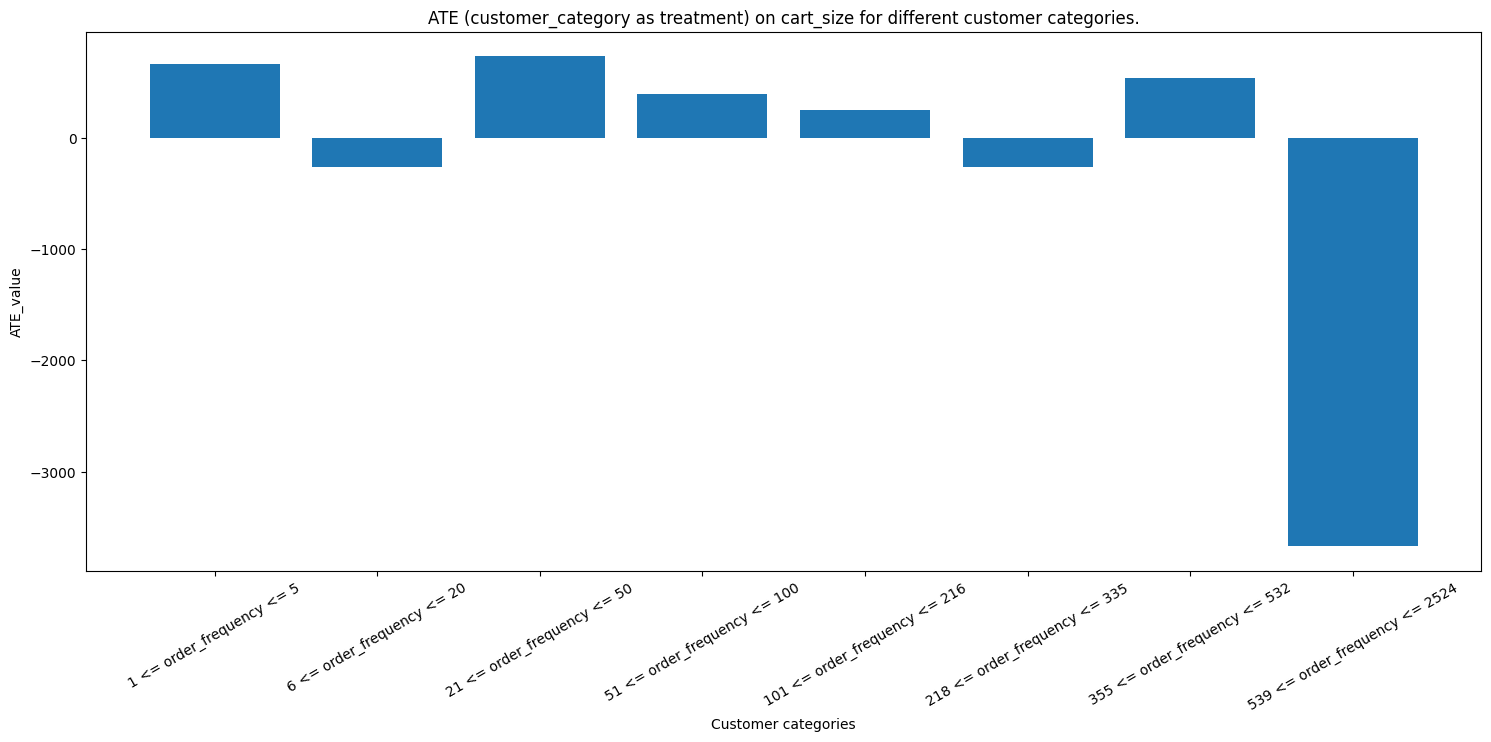

In [ ]:
lis_ate,lis_cat = ate_cal(new_data, "customer_category", ["Month","discount","payment_method","sales commision","Year"], 'mean')
plt.figure(figsize=(18,7))
plt.xticks(rotation = 30)
plt.bar(lis_cat,lis_ate)
plt.title("ATE (customer_category as treatment) on cart_size for different customer categories.")
plt.xlabel("Customer categories")
plt.ylabel("ATE_value")
plt.show()

1 <= order_frequency <= 5
ATE of sales commision (1) for people devided into subgroups on the basis of ['Month', 'discount', 'payment_method', 'Year', 'category_name_1']:
overall ATE calculated for impact of being in customer class: 1:  5597.3334745489965
overall ATE calculated for impact of being in customer class: 1 (conditioned on ['Month', 'discount', 'payment_method', 'Year', 'category_name_1']): 1675.6450546699966
p_value (statistical significance) without conditioning:  2.3120719204790582e-32

ATE of discount (1) for people devided into subgroups on the basis of ['Month', 'payment_method', 'Year', 'sales commision', 'category_name_1']:
overall ATE calculated for impact of being in customer class: 1:  6454.985527280332
overall ATE calculated for impact of being in customer class: 1 (conditioned on ['Month', 'payment_method', 'Year', 'sales commision', 'category_name_1']): -1338.0492367618554
p_value (statistical significance) without conditioning:  2.0940906960617333e-83

ATE of 

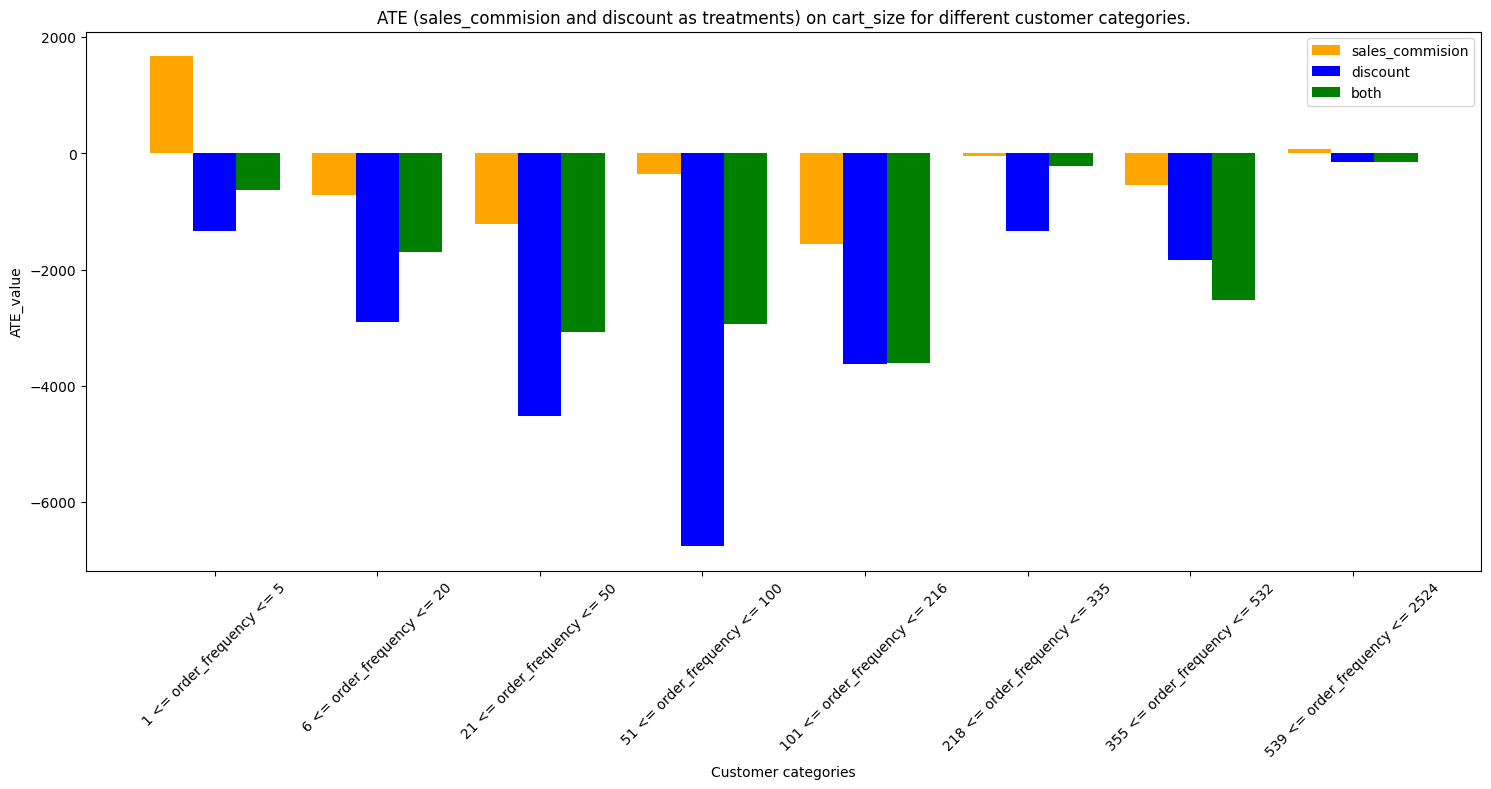

In [ ]:
lis_ate = []
lis_cat = []
lis_ate2 = []
lis_ate3 = []
un = np.array(sorted(new_data["customer_category"].unique(),key=lambda x: pd.to_numeric(x.split()[0])))
new_data["both"] = (new_data["discount_amount"] > 0) & (new_data["sales_commission_code"] != "\\N").astype(int)
for i in un:
    print(i)
    import scipy
    lis_cat.append(i)
    ans,_ = ate_cal(new_data.loc[new_data["customer_category"] == i], "sales commision", ["Month","discount","payment_method","Year","category_name_1"], 'mean')
    an2,_ = ate_cal(new_data.loc[new_data["customer_category"] == i], "discount", ["Month","payment_method","Year","sales commision","category_name_1"], 'mean')
    ans3,_ = ate_cal(new_data.loc[new_data["customer_category"] == i], "discount and sales commision", ["Month","payment_method","Year","category_name_1"], 'mean')
    lis_ate.append(ans[0])
    lis_ate2.append(an2[0])
    lis_ate3.append(ans3[0])
    #print(f"p_val = {p_value}")

width = 0.8
bar1 = [3*i for i in range(len(lis_cat))]
bar2 = [i + width for i in bar1]
bar3 = [i + width for i in bar2]
plt.figure(figsize=(18,7))
plt.bar(bar1, lis_ate,width, label = "sales_commision", color="orange")
plt.bar(bar2, lis_ate2,width, label = "discount" , color="blue")
plt.bar(bar3, lis_ate3,width, label = "both", color="green")
plt.xticks(bar2, lis_cat)
plt.title("ATE (sales_commision and discount as treatments) on cart_size for different customer categories.")
plt.xlabel("Customer categories")
plt.ylabel("ATE_value")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

**NULL hypothesis: There is no impact of customer category on product category**


**Alternative hypothesis: There is an effect of customer category on product category**

In [ ]:
contingency_table = pd.crosstab(new_data['customer_category'], new_data['category_name_1'])
# Step 2: Perform the Chi-Square Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)


Chi-Square Statistic: 71487.2577993399
P-value: 0.0
Degrees of Freedom: 98


**we reject the NULL hypothesis, because p value is much smaller than 0.05**